In [5]:
import requests
import xml.etree.ElementTree as ET
from datetime import datetime
import pytz
import pyshorteners

In [6]:
# Campo para digitar o assunto da pesquisa
#assunto = input("Digite o assunto da pesquisa: ")
assunto = "policia militar"


# Montar a URL de busca no Google News RSS
query = assunto.replace(" ", "%20")
url = f"https://news.google.com/rss/search?hl=pt-BR&gl=BR&ceid=BR:pt-419&oc=11&q={query}%20when:1d"

In [16]:
# Fazer a requisição
response = requests.get(url)

if response.status_code == 200:
    xml_content = response.text
    root = ET.fromstring(xml_content)

    noticias = []

    for item in root.findall('.//item'):
        title = item.find('title').text
        link = item.find('link').text
        pub_date = item.find('pubDate').text
        source = item.find('source').text if item.find('source') is not None else "Desconhecida"

        # Converter data para o horário de Brasília
        data_obj = datetime.strptime(pub_date, '%a, %d %b %Y %H:%M:%S GMT').replace(tzinfo=pytz.utc)
        data_brasilia = data_obj.astimezone(pytz.timezone('America/Sao_Paulo'))
        data_formatada = data_brasilia.strftime('%d/%m/%Y %H:%M:%S')

        noticias.append({
            'titulo': title,
            'link': link,
            'midia': source,
            'data': data_formatada
        })

    # Ordenar pela data
    noticias.sort(key=lambda x: x['data'], reverse=True)

    # Nome do arquivo de saída
    nome_arquivo = f"noticias.txt"

    with open(nome_arquivo, "w", encoding="utf-8") as f:
        for noticia in noticias:
            f.write(f"[{noticia['data']}] ({noticia['midia']}) {noticia['titulo']}\n")
            f.write(f"{noticia['link']}\n\n")

    print(f"{len(noticias)} notícias salvas em '{nome_arquivo}'.")

else:
    print("Erro ao buscar notícias:", response.status_code)


100 notícias salvas em 'noticias.txt'.


In [ ]:
#encurtar urls se quiser

import pyshorteners

# Inicializar o encurtador
shortener = pyshorteners.Shortener()

# Abrir o arquivo original
with open("noticias.txt", "r", encoding="utf-8") as f:
    linhas = f.readlines()

# Lista para armazenar o novo conteúdo
linhas_encurtadas = []

for i in range(0, len(linhas), 3):  # cada notícia ocupa 3 linhas (info, link, quebra de linha)
    info = linhas[i].strip()
    link_original = linhas[i+1].strip()
    quebra = linhas[i+2] if i+2 < len(linhas) else "\n"

    # Tentar encurtar a URL
    try:
        link_encurtado = shortener.tinyurl.short(link_original)
    except Exception as e:
        link_encurtado = link_original  # fallback se falhar

    # Adicionar ao novo conteúdo
    linhas_encurtadas.append(f"{info}\n")
    linhas_encurtadas.append(f"{link_encurtado}\n")
    linhas_encurtadas.append(quebra)

# Escrever no novo arquivo
with open("noticias_encurtadas.txt", "w", encoding="utf-8") as f:
    f.writelines(linhas_encurtadas)

print("Arquivo 'noticias_encurtadas.txt' criado com sucesso!")


AQUI VAMOS FAZER A ANALISE DE SENTIMENTO


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from transformers import pipeline

Device set to use cpu


,titulo,link,sentimento,texto
0,Polícia Militar liberta família de cárcere apr...,https://news.google.com/rss/articles/CBMitAFBV...,Negativo,Polícia Militar liberta família de cárcere apr...
1,Polícia Militar prende suspeito de roubo em Ma...,https://news.google.com/rss/articles/CBMitgFBV...,Negativo,Polícia Militar prende suspeito de roubo em Ma...
2,PM prende indivíduo com mandado de prisão em a...,https://news.google.com/rss/articles/CBMixAFBV...,Negativo,PM prende indivíduo com mandado de prisão em a...
3,Polícia Militar apreende arma de fogo após den...,https://news.google.com/rss/articles/CBMiugFBV...,Negativo,Polícia Militar apreende arma de fogo após den...
4,Polícia Militar prende homem por tráfico e apr...,https://news.google.com/rss/articles/CBMizAFBV...,Negativo,Polícia Militar prende homem por tráfico e apr...
...,...,...,...,...
95,Marinha descontamina Corregedoria Geral da Pol...,https://news.google.com/rss/articles/CBMirgFBV...,Negativo,Marinha descontamina Corregedoria Geral da Pol...
96,Policia Militar prende grupo suspeito de furta...,https://news.google.com/rss/articles/CBMi3wFBV...,Negativo,Policia Militar prende grupo suspeito de furta...
97,Polícia Militar prende suspeito por tentativa ...,https://news.google.com/rss/articles/CBMirwFBV...,Negativo,Polícia Militar prende suspeito por tentativa ...
98,Major da Polícia Militar morre após cair de mo...,https://news.google.com/rss/articles/CBMiugFBV...,Negativo,Major da Polícia Militar morre após cair de mo...


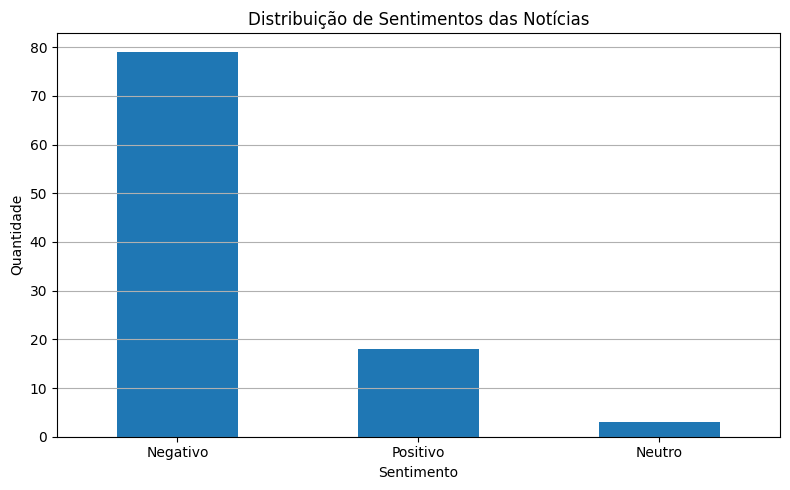

In [25]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Nome do arquivo gerado anteriormente
nome_arquivo = "noticias.txt"

# Carregar títulos e links
noticias = []
with open(nome_arquivo, "r", encoding="utf-8") as f:
    linhas = f.readlines()
    for i in range(0, len(linhas), 3):  # Cada notícia tem 3 linhas: info, link, quebra de linha
        linha_info = linhas[i].strip()
        link = linhas[i+1].strip()
        titulo = linha_info.split(") ")[-1]  # extrair apenas o título
        noticias.append({"titulo": titulo, "link": link})

# Carregar modelo de análise de sentimento
analisador = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Fazer análise de sentimento apenas com o título
for noticia in noticias:
    texto_para_analisar = noticia["titulo"]

    try:
        resultado = analisador(texto_para_analisar[:512])[0]
        estrela = resultado['label']
        if estrela in ['1 star', '2 stars']:
            sentimento = 'Negativo'
        elif estrela == '3 stars':
            sentimento = 'Neutro'
        else:
            sentimento = 'Positivo'
    except Exception as e:
        print(f"Erro ao analisar sentimento de: {noticia['titulo']}")
        sentimento = "Indefinido"

    noticia["sentimento"] = sentimento
    noticia["texto"] = texto_para_analisar  # apenas para manter compatível com o DataFrame

# Criar DataFrame
df = pd.DataFrame(noticias)
df = df[df["sentimento"] != "Indefinido"]

# Exibir tabela
display(df)

# Gráfico de distribuição dos sentimentos
if not df.empty:
    sentimentos = df["sentimento"].value_counts()
    plt.figure(figsize=(8, 5))
    sentimentos.plot(kind="bar")
    plt.title("Distribuição de Sentimentos das Notícias")
    plt.xlabel("Sentimento")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma notícia válida para análise de sentimento.")


In [ ]:
import openai
import time
import pandas as pd

# ✅ Coloque sua chave da API aqui
openai.api_key = ""

# Nome do arquivo com os títulos
nome_arquivo = "noticias.txt"

# Carregar títulos e links
noticias = []
with open(nome_arquivo, "r", encoding="utf-8") as f:
    linhas = f.readlines()
    for i in range(0, len(linhas), 3):  # Cada notícia tem 3 linhas: info, link, quebra de linha
        linha_info = linhas[i].strip()
        link = linhas[i+1].strip()
        titulo = linha_info.split(") ")[-1]  # extrair só o título
        noticias.append({"titulo": titulo, "link": link})

# Função para chamada da API (versão 1.x)
def analisar_sentimento_institucional(titulo, instituicao="Polícia Militar"):
    prompt = (
        f"Avalie o sentimento da seguinte manchete de notícia em relação à instituição '{instituicao}':\n"
        f"\"{titulo}\"\n"
        "Responda com apenas uma palavra: Positiva, Negativa ou Neutra. "
        "Considere se a notícia representa a instituição de forma favorável, desfavorável ou neutra."
    )

    try:
        response = openai.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Erro ao analisar título: {titulo}\n{e}")
        return "Indefinido"

# Aplicar análise
for noticia in noticias:
    sentimento = analisar_sentimento_institucional(noticia["titulo"])
    noticia["sentimento"] = sentimento
    time.sleep(1)  # evitar rate limit

# Criar DataFrame e exibir
df = pd.DataFrame(noticias)
df = df[df["sentimento"] != "Indefinido"]
print(df)

# Salvar CSV
df.to_csv("noticias_com_sentimento_chatgpt.csv", index=False, encoding="utf-8")
print("Análise concluída e salva em 'noticias_com_sentimento_chatgpt.csv'")


Erro ao analisar título: Polícia Militar liberta família de cárcere apreende e duas armas de fogo no ramal Benfica - AcreNews


You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Erro ao analisar título: Polícia Militar prende suspeito de roubo em Maravilha - DI Regional


You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to 

KeyboardInterrupt: 

In [21]:
print(df.loc[0, "texto"])


We use cookies and data to If you choose to “Accept all,” we will also use cookies and data to If you choose to “Reject all,” we will not use cookies for these additional purposes. Non-personalized content is influenced by things like the content you’re currently viewing, activity in your active Search session, and your location. Non-personalized ads are influenced by the content you’re currently viewing and your general location. Personalized content and ads can also include more relevant results, recommendations, and tailored ads based on past activity from this browser, like previous Google searches. We also use cookies and data to tailor the experience to be age-appropriate, if relevant. Select “More options” to see additional information, including details about managing your privacy settings. You can also visit g.co/privacytools at any time.


,titulo,link,texto,sentimento


IndexError: index 0 is out of bounds for axis 0 with size 0

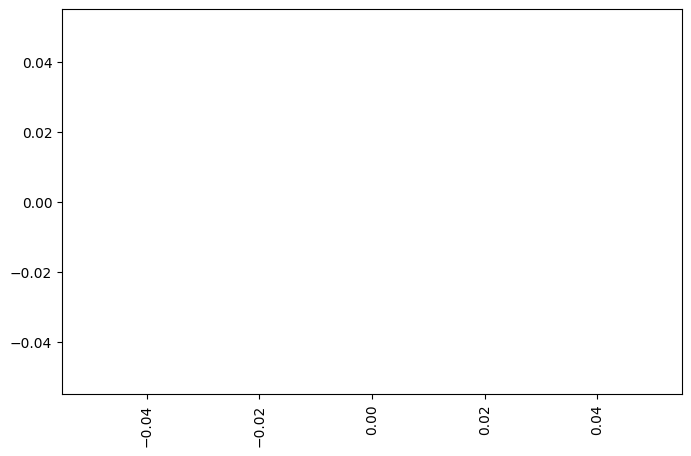

In [19]:
# Criar DataFrame
df = pd.DataFrame(noticias)
df = df[df["sentimento"] != "Indefinido"]  # opcional: remover as falhas

# Exibir tabela (compatível com Jupyter local)
from IPython.display import display
display(df)

# Gráfico
sentimentos = df["sentimento"].value_counts()

plt.figure(figsize=(8, 5))
sentimentos.plot(kind="bar")
plt.title("Distribuição de Sentimentos das Notícias")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
